## Import, Clean, Select and/or Create Data

- Import libraries
- If selected, either:
    - Read TeleMetrum or TeleMega data, in which case also:
        - Remove the collected data for which the rocket was either:
            - on the pad and not started motor burn
            - landed and not moving   
        - The TeleMega didn't start capturing velocity data until shortly before apogee, so I add an approximation based on integration of the acceleration data for the missing points
        - Correct temperatures to what the temperature would be on the outside of the rocket by using the standard temperature lapse rate
    - Define custom flightpath
- Define helper functions

In [119]:
# Select Data
dataset_choice = 'custom' # options: telemetrum, telemega, custom

In [120]:
# import libraries, import data, clean data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if dataset_choice == 'telemetrum':
    telemetrum_data = pd.read_csv('2022-06-24-serial-5115-flight-0001.csv',skiprows=range(1,23)).iloc[:-258].drop_duplicates().reset_index()

if dataset_choice == 'telemega':
    telemega_data = pd.read_csv('2022-06-24-serial-6583-flight-0003.csv',skiprows=range(1,18)).iloc[:-216].drop_duplicates().reset_index()

    for i in range(3):
        telemega_data.at[i, 'speed'] = 0
    for i in range(len(telemega_data)-3):
        if telemega_data['speed'][i] == '     NaN':
            telemega_data.at[i, 'speed'] = telemega_data['acceleration'][i]*(telemega_data['time'][i]-telemega_data['time'][i-1]) + telemega_data['speed'][i-1]

# todo:
    # make smoothed versions? take out outliers?
    # ultimate goal: make it so other parameters can be input, like other thrust curves, other ground temps/pressures (like in report 1 sim), other rocket masses, etc

In [121]:
# Helper functions
def temp_at_height(altitude, temp_at_launch_site):
    return temp_at_launch_site - (altitude*6.5*pow(10,-3))

def pressure_at_height(altitude, temp_at_launch_site):
    return 1000*87*(pow((1-(altitude*6.5*pow(10,-3)/(temp_at_launch_site+273.15))),(9.80665*0.0289644/(8.3144598*6.5*pow(10,-3))))) # Pressure at the launch site was around 87 kPa for Prometheus' launch

In [122]:
# Set dataset, fix temperature for Prometheus datasets
if dataset_choice == 'telemetrum':
    dataset = telemetrum_data
elif dataset_choice == 'telemega':
    dataset = telemega_data
elif dataset_choice == 'custom':
    dataset = pd.DataFrame(columns=['time','height','speed','acceleration','temperature','pressure'])

if not dataset_choice == 'custom': 
    dataset['temperature'] = dataset['height'].apply(lambda x: temp_at_height(x,dataset['temperature'][0]))
    def thrust_at_time(time): # as per https://www.csrocketry.com/rocket-motors/cesaroni/motors/pro-98/3g-reloads/cesaroni-m1520-blue-streak-rocket-motor.html
        if time < 2.5: return 1785
        elif time <4.5: return 1785 - (time-2.5)*(1785-1340)/2
        elif time <4.9: return 1340 - (time - 4.5)*(1340)/0.4
        else: return 0
    def mass_at_time(time):
        if time <4.9: return 20.51-(time*(20.51-16.91)/4.9)
        else: return 16.91

In [123]:
# Custom flight parameters
if dataset_choice == 'custom':
    sim_end = 60
    timesteps = 10000
    temp_at_launchpad = 30 # deg C
    def thrust_at_time(time): # as per https://www.csrocketry.com/rocket-motors/cesaroni/motors/pro-98/3g-reloads/cesaroni-m1520-blue-streak-rocket-motor.html
        if time < 2.5: return 1785
        elif time <4.5: return 1785 - (time-2.5)*(1785-1340)/2
        elif time <4.9: return 1340 - (time - 4.5)*(1340)/0.4
        else: return 0
    def mass_at_time(time):
        if time <4.9: return 20.51-(time*(20.51-16.91)/4.9)
        else: return 16.91

# Simulate custom flight
    timestep = (sim_end/timesteps)
    timespace = np.linspace(0,sim_end,timesteps)
    cd_rocket = 0.35 # VERY rough, depends on mach number, other characteristics
    A_rocket = 0.015326 # 5.5" diameter circle's area in m^2
    half_A_cd_rocket = 0.5*cd_rocket*A_rocket
    
    speed, height = 0, 0
    temperature = temp_at_height(0,temp_at_launchpad)
    pressure = pressure_at_height(0,temp_at_launchpad)

    heights, speeds, accels, temps, pressures = [], [], [], [], []
    
    for i in range(1, timesteps):
        F_drag = half_A_cd_rocket*(pressure/((temperature+273.15)*287.05)) * (speed**2)
        acceleration = (thrust_at_time(timespace[i])-F_drag)/mass_at_time(timespace[i]) - 9.81
        speed += acceleration*timestep
        height += speed*timestep
        temperature = temp_at_height(height,temp_at_launchpad)        
        pressure = pressure_at_height(height,temp_at_launchpad)

        heights.append(height)
        speeds.append(speed)
        accels.append(acceleration)
        temps.append(temperature)
        pressures.append(pressure)
        if speed <=0: break
    
    data = {
    'time': timespace[0:len(heights)],
    'speed': speeds,
    'height': heights,
    'acceleration': accels,
    'temperature': temps,
    'pressure': pressures
    }
    dataset = pd.DataFrame(data)

## Ascent Overview

(we don't really care about what happends after apogee; that's when our job finishes. Well, maybe we'll want them to retract at apogee, but if it's survived to apogee, that's the main goal)

In [124]:
# Set graph units
imperial = True

             Height (ft)  Speed (ft/s)  Accel (ft/s^2)  Time (s)
Max-g Force       517.80        520.31          263.99      1.99
Burnout          2878.04       1111.13            0.66      4.76
Apogee          14612.44          0.31          -32.19     29.89


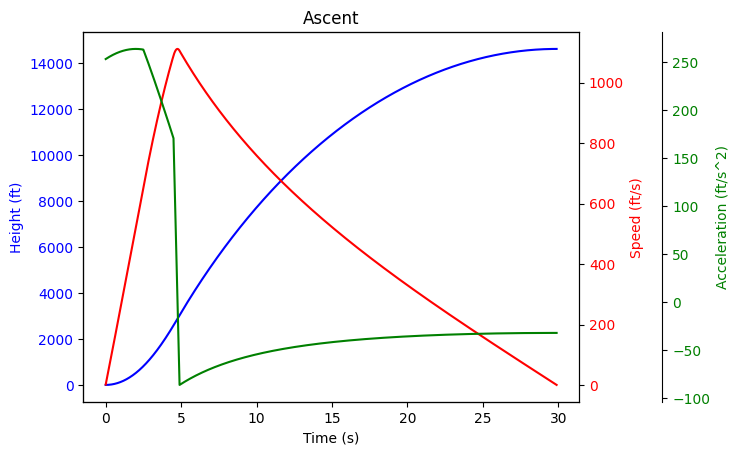

In [125]:
if dataset_choice != 'custom':
    # last 5 data points taken off so that the affects due to chute deployment at apogee aren't considered
    apogee_index = dataset['height'].idxmax()-5 
else:
    apogee_index = dataset['height'].idxmax()

burnout_index = dataset['speed'].idxmax()
max_g_index = dataset['acceleration'].idxmax()

time = dataset['time'][0:apogee_index]
height = dataset['height'][0:apogee_index].copy()
speed = dataset['speed'][0:apogee_index].copy()
accel = dataset['acceleration'][0:apogee_index].copy()
unit = 'm'
if imperial: 
    height *= 3.281
    speed *= 3.281 
    accel *= 3.281
    unit = 'ft'

parameters_at_flight_events = pd.DataFrame({
    f'Height ({unit})': [round(height.iloc[max_g_index],2), round(height.iloc[burnout_index],2), round(height.iloc[-1],2)],
    f'Speed ({unit}/s)': [round(speed.iloc[max_g_index],2), round(speed.iloc[burnout_index],2), round(speed.iloc[-1],2)],
    f'Accel ({unit}/s^2)': [round(accel.iloc[max_g_index],2), round(accel.iloc[burnout_index],2), round(accel.iloc[-1],2)],
    'Time (s)': [round(time.iloc[max_g_index],2), round(time.iloc[burnout_index],2), round(time.iloc[-1],2)]
}, index=['Max-g Force', 'Burnout', 'Apogee'])
print(parameters_at_flight_events)

fig, ax1 = plt.subplots()
ax1.plot(time, height, color='b', label='Dataset 1')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, speed, color='r', label='Dataset 2')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(time, accel, color='g', label='Dataset 3')
ax3.set_ylabel(f'Acceleration ({unit}/s^2)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

plt.title('Ascent')
plt.show()

## Max-q and Max g-force during ascent

Max g-force during ascent is:
8.2019 g
Max-q during ascent is:
52.906 kPa


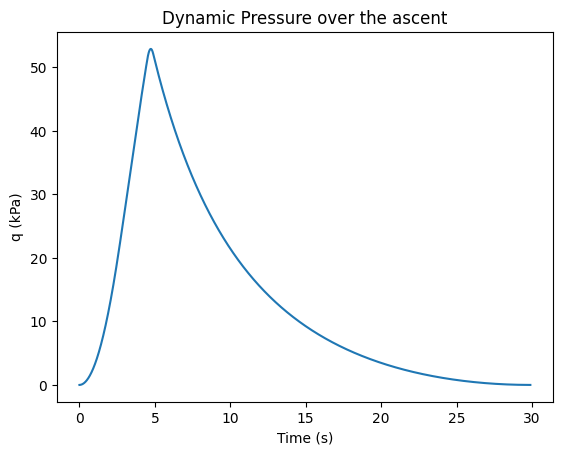

In [126]:
max_a = max(dataset['acceleration'][0:apogee_index])
print('Max g-force during ascent is:')
print(str(max_a/9.81)[0:6] + ' g')

air_density = (dataset['pressure'][0:apogee_index])/((dataset['temperature'][0:apogee_index]+273.15)*287.05)
q = 0.5 * (air_density/1000) * ((dataset['speed'][0:apogee_index])**2)

# note: plotting pressure against hieght of both datasets on both ascent and descent shows them to be nearly identical. Given the significant change in speed on the way up vs the way down, this suggests that the pressure inside the av bay (which is what's read by the sensors) changes nearly instantaneously with the pressure outside, at least as far as it makes a difference for the changing rates in the max-q calculation. <- check if also consistent with other sim, note if it is

print('Max-q during ascent is:')
print(str(max(q))[0:6] + ' kPa')
plt.plot(dataset['time'][0:apogee_index],q[0:apogee_index])
plt.xlabel('Time (s)')
plt.ylabel('q (kPa)')
plt.title('Dynamic Pressure over the ascent')
plt.show()

## Slowing Down with Airbrakes

In [127]:
# Define PID controller class
class PIDController:
    def __init__(self, Kp, Ki, Kd, setpoint):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.prev_error = 0
        self.integral = 0

    def calculate(self, process_variable, dt):
        error = self.setpoint - process_variable
        if error > 0:
            self.integral += error * dt
            derivative = (error - self.prev_error) / dt
            output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
            output = min(output, 45)
            output = max(output, 0)
            self.prev_error = error
        else:
            output = 45
        return output

In [128]:
# airbrake, rocket parameters
num_flaps = 4
A_flap = 0.011408 # current area in CAD. Likely to decrease
A_brakes = A_flap * num_flaps
cd_brakes = 0.6 # about what other teams had, super rough
cd_rocket = 0.35 # VERY rough, depends on mach number, other characteristics
A_rocket = 0.015326 # 5.5" diameter circle's area in m^2
max_deployment_speed = 10 #deg/s
temp_at_launchpad = 30

# set flightpath until airbrake deployment as identical
motor_burnout = dataset[(dataset.index > 50) & (dataset['acceleration'] < 0)].head(1).index[0]
airbrake_deployment = motor_burnout + 5 # +30 gives Prometheus about 10k apogee if total deployment happens then (slightly different but pretty similar b/w telemega and telemetrum)
pre_brake_flight = dataset.head(airbrake_deployment).copy()
pre_brake_flight['deployment_angle']=0

# deploy airbrakes and see how flighpath changes. recalc everything at each timestep from moment deployed
height = pre_brake_flight['height'].iloc[-1]
deployment_height = height
speed = pre_brake_flight['speed'].iloc[-1]
time = pre_brake_flight['time'].iloc[-1]
mass = mass_at_time(pre_brake_flight['time'].iloc[-1])
timestep = 0.001
airbrake_flight = []
deployment_angle = 0

# define PID controller
Kp = 1
Ki = 0
Kd = 0.4
setpoint = (10000/3.281) - deployment_height
pid = PIDController(Kp, Ki, Kd, setpoint)

# for efficiency, may be removed when the simulation is made more accurate by the cds changing during the sim:
A_cd_brakes = A_brakes*cd_brakes
A_cd_rocket = A_rocket*cd_rocket

while speed > 0:
    time += timestep

    temperature = temp_at_height(height - deployment_height,temp_at_launchpad)
    pressure = pressure_at_height(height,temp_at_launchpad)
    q = 0.5 * (pressure/((temperature+273.15)*287.05)) * (speed**2)

    PID_output = pid.calculate(height-deployment_height, timestep) 

    if PID_output>deployment_angle:
        deployment_angle = min(45, deployment_angle + max_deployment_speed*timestep)
    elif PID_output<deployment_angle:
        deployment_angle = max(0, deployment_angle - max_deployment_speed*timestep) 

    acceleration = -9.81-(np.sin(np.deg2rad(deployment_angle))*A_cd_brakes+A_cd_rocket)*q/mass
    height += speed*timestep
    speed += acceleration*timestep

    new_data = {
        'time': time,
        'height': height,
        'speed': speed,
        'temperature': temperature,
        'pressure': pressure,
        'acceleration': acceleration,
        'deployment_angle': deployment_angle
    }
    airbrake_flight.append(new_data)

whole_flight = pd.concat([pre_brake_flight, pd.DataFrame(airbrake_flight)], ignore_index=True)
print(dataset['height'][apogee_index]*3.281)
print(height*3.281)

# how high should the rocket overshoot without deployment, motor selction
# at what point during flight would we deploy?

14612.437509725249
9949.038537957314


In [129]:
# Plot new flight profile
imperial = True

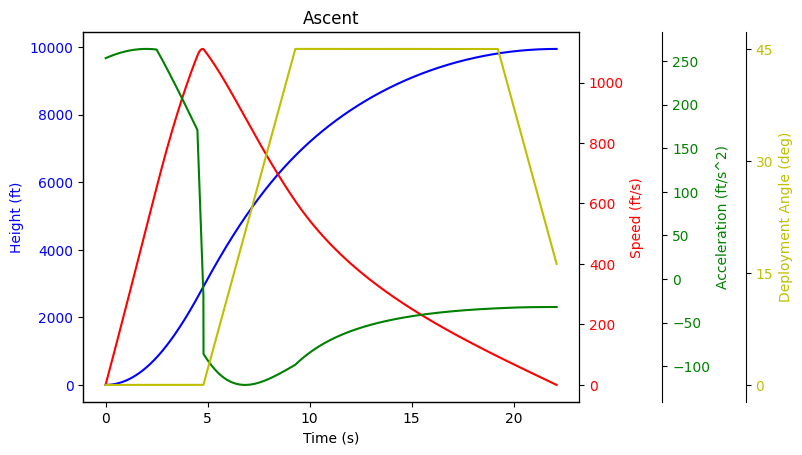

In [130]:
time = whole_flight['time'].copy()
height = whole_flight['height'].copy()
speed = whole_flight['speed'].copy()
accel = whole_flight['acceleration'].copy()
deployment_angle = whole_flight['deployment_angle']
unit = 'm'
if imperial: 
    height *= 3.281
    speed *= 3.281 
    accel *= 3.281
    unit = 'ft'

fig, ax1 = plt.subplots()
ax1.plot(time, height, color='b')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(f'Height ({unit})', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, speed, color='r')
ax2.set_ylabel(f'Speed ({unit}/s)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(time, accel, color='g')
ax3.set_ylabel(f'Acceleration ({unit}/s^2)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(time, deployment_angle, color='y')
ax4.set_ylabel(f'Deployment Angle (deg)', color='y')
ax4.tick_params(axis='y', labelcolor='y')
ax4.set_yticks(range(0, 46, 15))

plt.title('Ascent')
plt.show()